In [1]:
import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

import tensorflow as tf


# app = Flask(__name__)
# from nltk.tag import pos_tag
# from nltk.corpus import wordnet
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# from transformers import BertTokenizer
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.regularizers import l2

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# nltk downloads and stopwords
# stop_words = stopwords.words("english")
# lemmatizer= WordNetLemmatizer()
# nltk.download('wordnet')#, download_dir = '/root/nltk_data/')
# nltk.download('omw-1.4')#, download_dir = '/root/nltk_data/')
# # !unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/
# !unzip /root/nltk_data/corpora/omw-1.4.zip -d /root/nltk_data/corpora/

In [2]:
##### model_name = "t5-small"  
# tokenizer = T5Tokenizer.from_pretrained(model_name)
# model = TFT5ForConditionalGeneration.from_pretrained(model_name)
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = TFT5ForConditionalGeneration.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [3]:
# import tensorflow as tf
# from transformers import TFT5ForConditionalGeneration

def shift_right(input_ids, pad_token_id, decoder_start_token_id):
    """
    Shifts input ids to the right by one position.
    The first token becomes the decoder_start_token_id.
    """
    batch_size = tf.shape(input_ids)[0]
    start_tokens = tf.fill([batch_size, 1], decoder_start_token_id)
    shifted_input_ids = tf.concat([start_tokens, input_ids[:, :-1]], axis=1)
    return shifted_input_ids

class MultiTaskT5(tf.keras.Model):
    def __init__(self, model_name, num_emotion_labels, num_sentiment_labels):
        super(MultiTaskT5, self).__init__()
        self.t5 = TFT5ForConditionalGeneration.from_pretrained(model_name)
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.emotion_classifier = tf.keras.layers.Dense(
            num_emotion_labels, activation='softmax', name="emotion_classifier"
        )
        self.sentiment_classifier = tf.keras.layers.Dense(
            num_sentiment_labels, activation='softmax', name="sentiment_classifier"
        )

    def call(self, inputs, task, training=False, labels=None):
        if task in ['emotion', 'sentiment']:
            encoder_outputs = self.t5.encoder(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                training=training
            )
            pooled_output = tf.reduce_mean(encoder_outputs.last_hidden_state, axis=1)
            pooled_output = self.dropout(pooled_output, training=training)
            if task == 'emotion':
                return self.emotion_classifier(pooled_output)
            else:
                return self.sentiment_classifier(pooled_output)
        elif task == 'summary':
            if labels is None:
                outputs = self.t5(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    training=training
                )
                return outputs.logits
            else:
                pad_token_id = self.t5.config.pad_token_id
                decoder_start_token_id = self.t5.config.decoder_start_token_id
                decoder_input_ids = shift_right(labels, pad_token_id, decoder_start_token_id)
                outputs = self.t5(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    decoder_input_ids=decoder_input_ids,
                    training=training
                )
                return outputs.logits
        else:
            raise ValueError("Unsupported task type. Use 'emotion', 'sentiment', or 'summary'.")

# --- Instantiate Model and Tokenizer ---
model_name = "t5-small"
num_emotion_labels = 6
num_sentiment_labels = 4  # Updated to 4 output labels for sentiment
model = MultiTaskT5(model_name, num_emotion_labels, num_sentiment_labels)
tokenizer = T5Tokenizer.from_pretrained(model_name)
        

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [4]:
columns_name_train={
    "Positive": "sentiment",
    "im getting on borderlands and i will murder you all ,": "review",
}
columns_name_test={
    "Irrelevant": "sentiment",
    "I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣": "review",
}

In [5]:
# Read datasets for emotion /kaggle/input/sentiment-emotion-dataset/train.txt
df_train_emo = pd.read_csv('/kaggle/input/sentiment-emotion-dataset/train.txt', names=['Text', 'Emotion'], sep=';')[:5000]
df_val_emo = pd.read_csv('/kaggle/input/sentiment-emotion-dataset/val.txt', names=['Text', 'Emotion'], sep=';')
df_test_emo = pd.read_csv('/kaggle/input/sentiment-emotion-dataset/test.txt', names=['Text', 'Emotion'], sep=';')
# df_train_emosentiment_df = pd.read_csv("/kaggle/input/t5-fine-tune-for-sentiment-detection/IMDB Dataset.csv")  # Expect columns 'review' and 'sentiment'
# Read Sentiment data
df_train_sen =  pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",index_col='2401')[['Positive','im getting on borderlands and i will murder you all ,']].rename(columns=columns_name_train)[:5000]
# df_train_sen, df_test_sen = sk.model_selection.train_test_split(df_sen,test_size=0.1,random_state=42)
df_test_sen = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", index_col='3364')[['Irrelevant','I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣']].rename(columns=columns_name_test)
df_train_sen.columns,df_test_sen.columns,

(Index(['sentiment', 'review'], dtype='object'),
 Index(['sentiment', 'review'], dtype='object'))

In [6]:
df_train_emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     5000 non-null   object
 1   Emotion  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [7]:
df_train_sen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2401 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  5000 non-null   object
 1   review     4952 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [8]:
from datasets import load_dataset
df_summ = load_dataset("cnn_dailymail", "3.0.0")
df_summ

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [9]:
df_train_summ = df_summ['train'][:5000]
df_val_summ   = df_summ['validation']
df_test_summ  = df_summ['test']
df_train_summ = pd.concat([pd.Series(df_train_summ['article']),pd.Series(df_train_summ['highlights'])],axis=1).rename(columns={0: 'article', 1: 'highlights'})
df_val_summ = pd.concat([pd.Series(df_val_summ['article']),pd.Series(df_val_summ['highlights'])],axis=1).rename(columns={0: 'article', 1: 'highlights'})
df_test_summ = pd.concat([pd.Series(df_test_summ['article']),pd.Series(df_test_summ['highlights'])],axis=1).rename(columns={0: 'article', 1: 'highlights'})
df_train_summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     5000 non-null   object
 1   highlights  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [10]:
#check if the data is balanced or not
df_train_emo.Emotion.value_counts() / df_train_emo.shape[0] *100

Emotion
joy         34.06
sadness     28.86
anger       13.42
fear        11.68
love         8.02
surprise     3.96
Name: count, dtype: float64

In [11]:
df_train_sen.sentiment.value_counts()/df_train_sen.shape[0]*100

sentiment
Positive      38.74
Neutral       23.34
Negative      21.12
Irrelevant    16.80
Name: count, dtype: float64

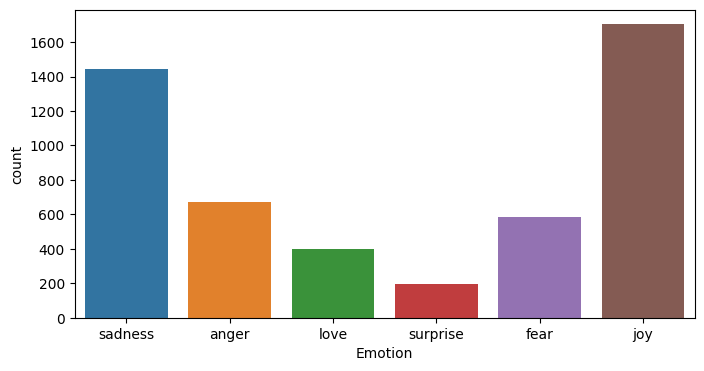

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train_emo);

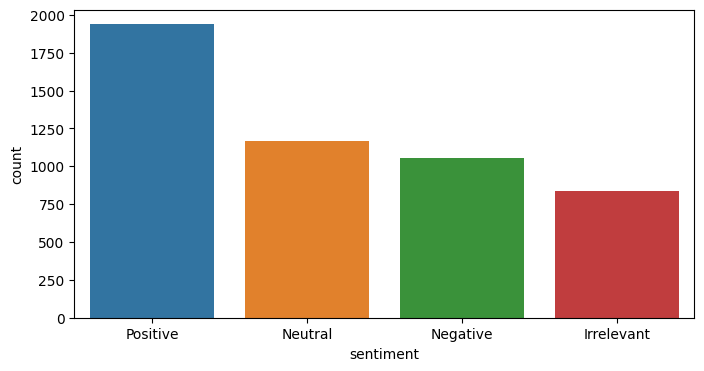

In [13]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_train_sen);

In [14]:
#print the number of null values in each column
df_train_emo.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [15]:
#print the number of null values in each column
df_train_sen.isnull().sum()

sentiment     0
review       48
dtype: int64

In [16]:
#print the number of null values in each column
df_train_summ.isnull().sum()

article       0
highlights    0
dtype: int64

In [17]:
#print the number of duplicated values 
df_train_emo.duplicated().sum()

0

In [18]:
#print the number of duplicated values 
df_train_sen.duplicated().sum()

262

In [19]:
#print the number of duplicated values 
df_train_summ.duplicated().sum()

391

In [20]:
#removing duplicated values
index = df_train_emo[df_train_emo.duplicated() == True].index
df_train_emo.drop(index, axis = 0, inplace = True)
df_train_emo.reset_index(inplace=True, drop = True)

In [21]:
#removing duplicated values
index = df_train_sen[df_train_sen.duplicated() == True].index
df_train_sen.drop(index, axis = 0, inplace = True)
df_train_sen.reset_index(inplace=True, drop = True)

In [22]:
#removing duplicated values
index = df_train_summ[df_train_summ.duplicated() == True].index
df_train_summ.drop(index, axis = 0, inplace = True)
df_train_summ.reset_index(inplace=True, drop = True)

In [23]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train_emo[df_train_emo['Text'].duplicated() == True]

,Text,Emotion


In [24]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train_sen[df_train_sen['review'].duplicated() == True]

,sentiment,review
1060,Positive,you
1498,Positive,that
2482,Negative,It


In [25]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train_summ[df_train_summ['article'].duplicated() == True]

,article,highlights
2715,Congressman Jared Polis . (D) Colorado: Distri...,Video: Hand-held cams track freshmen moves .\n...


In [26]:
#print some of those rows to check
# df_train_emo[df_train_emo['Text'] == df_train_emo['Text'].iloc[5067]]

In [27]:
#print some of those rows to check
# df_train_summ[df_train_summ['article'] == df_train_summ['article'].iloc[2715]]

In [28]:
#removing duplicated text 
index = df_train_emo[df_train_emo['Text'].duplicated() == True].index
df_train_emo.drop(index, axis = 0, inplace = True)
df_train_emo.reset_index(inplace=True, drop = True)

In [29]:
#removing duplicated text 
index = df_train_sen[df_train_sen['review'].duplicated() == True].index
df_train_sen.drop(index, axis = 0, inplace = True)
df_train_sen.reset_index(inplace=True, drop = True)

In [30]:
#removing duplicated text 
index = df_train_summ[df_train_summ['article'].duplicated() == True].index
df_train_summ.drop(index, axis = 0, inplace = True)
df_train_summ.reset_index(inplace=True, drop = True)

In [31]:
#check if the data is balanced or not
df_test_emo.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [32]:
df_test_sen.sentiment.value_counts()

sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64

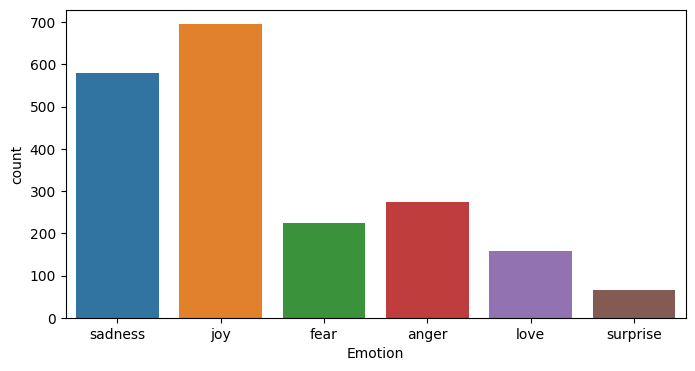

In [33]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test_emo);

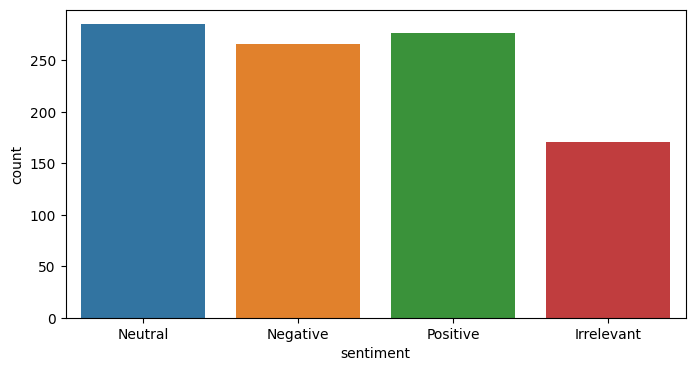

In [34]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_test_sen);

In [35]:
#print the number of null values in each column
df_test_emo.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [36]:
#print the number of null values in each column
df_test_sen.isnull().sum()

sentiment    0
review       0
dtype: int64

In [37]:
#print the number of null values in each column
df_train_summ.isnull().sum()

article       0
highlights    0
dtype: int64

In [38]:
#print the number of duplicated values 
df_test_emo.duplicated().sum()

0

In [39]:
#removing duplicated text 
index = df_test_sen[df_test_sen['review'].duplicated() == True].index
df_test_sen.drop(index, axis = 0, inplace = True)
df_test_sen.reset_index(inplace=True, drop = True)

In [40]:
#removing duplicated text 
index = df_test_summ[df_test_summ['article'].duplicated() == True].index
df_test_summ.drop(index, axis = 0, inplace = True)
df_test_summ.reset_index(inplace=True, drop = True)

In [41]:
#print the number of duplicated values 
df_test_sen.duplicated().sum()

0

In [42]:
#print the number of duplicated values 
df_test_summ.duplicated().sum()

0

In [43]:
#print the rows which are duplicated
df_test_emo[df_test_emo['Text'].duplicated() == True]

,Text,Emotion


In [44]:
#check if the data is balanced or not
df_val_emo.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

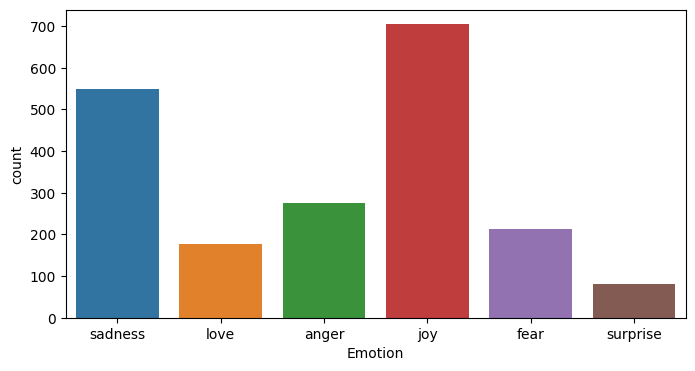

In [45]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val_emo);

In [46]:
#print the number of null values in each column
df_val_emo.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [47]:
#print the number of duplicated values 
df_val_emo.duplicated().sum()

0

In [48]:
#print the number of duplicated values 
df_val_summ.duplicated().sum()

0

In [49]:
#print the rows which are duplicated
df_val_emo[df_val_emo['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [50]:
#print the rows which are duplicated
df_val_summ[df_val_summ['article'].duplicated() == True]

,article,highlights


In [51]:
df_val_emo[df_val_emo['Text'] == df_val_emo['Text'][603]]

,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [52]:
# df_val_emo[df_val_emo['Text'] == df_val_emo['Text'][1993]]

In [53]:
#removing duplicated text
index = df_val_emo[df_val_emo['Text'].duplicated() == True].index
df_val_emo.drop(index, axis = 0, inplace = True)
df_val_emo.reset_index(inplace=True, drop = True)

In [54]:
df_train_sen.dropna()
df_train_sen.isna().sum()  # need to drop nan value causing the error to 


sentiment    0
review       1
dtype: int64

In [55]:
# def preprocess_texts(texts, max_length=128):
#     return tokenizer(texts.tolist(), padding=True, truncation=True,
#                      max_length=max_length, return_tensors="tf")
def preprocess_texts(texts, max_length=128):
    # Replace NaN with empty strings and ensure all values are strings
    texts = texts.fillna("").astype(str)
    return tokenizer(texts.tolist(), padding=True, truncation=True,
                     max_length=max_length, return_tensors="tf")


In [56]:
emotion_inputs = preprocess_texts(df_train_emo["Text"])
# Convert emotion labels (assumed to be strings) to integer codes
emotion_labels = tf.convert_to_tensor(df_train_emo["Emotion"].astype('category').cat.codes.tolist())


In [57]:
sentiment_inputs = preprocess_texts(df_train_sen["review"])

# Convert sentiment labels to  (3 if "positive", 2 neutral,1 negative 0 iirelavent ), using lower case for comparison.
sentiment_labels = tf.convert_to_tensor(
    df_train_sen["sentiment"].astype('category').cat.codes.tolist()
)

In [58]:
# def create_tf_dataset(inputs, labels, batch_size=8):
#     dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), labels))
#     return dataset.shuffle(1000).batch(batch_size)


df_train_sen["sentiment"],sentiment_labels
# Define mapping dictionary for the four categories


(0       Positive
 1       Positive
 2       Positive
 3       Positive
 4       Positive
           ...   
 3912     Neutral
 3913     Neutral
 3914     Neutral
 3915     Neutral
 3916     Neutral
 Name: sentiment, Length: 3917, dtype: object,
 <tf.Tensor: shape=(3917,), dtype=int32, numpy=array([3, 3, 3, ..., 2, 2, 2], dtype=int32)>)

In [59]:
def preprocess_summary_inputs(texts, max_input_length=512):
    """
    Preprocess input texts for summarization by adding the 'summarize: ' prefix
    and tokenizing.
    """
    # Add the summarization prefix to each text
    prefixed_texts = ["summarize: " + text for text in texts.tolist()]
    return tokenizer(prefixed_texts, padding="max_length", truncation=True,
                     max_length=max_input_length, return_tensors="tf")

def preprocess_summary_targets(targets, max_target_length=150):
    """
    Preprocess target summaries by tokenizing.
    """
    # Tokenize the target summaries; we only need the input_ids for targets.
    tokenized_targets = tokenizer(targets.tolist(), padding="max_length", truncation=True,
                                  max_length=max_target_length, return_tensors="tf")
    return tokenized_targets["input_ids"]

# Example usage:
# Assume summary_df is a DataFrame with columns "text" for source texts and "summary" for target summaries.
summary_inputs = preprocess_summary_inputs(df_train_summ["article"])
summary_labels = preprocess_summary_targets(df_train_summ["highlights"])


In [60]:
summary_labels

<tf.Tensor: shape=(4608, 150), dtype=int32, numpy=
array([[ 8929, 16023,  2213, ...,     0,     0,     0],
       [17054,   120,     3, ...,     0,     0,     0],
       [ 8747,    10,    96, ...,     0,     0,     0],
       ...,
       [ 9668,  6775,  1912, ...,     0,     0,     0],
       [ 6536,  4129,   117, ...,     0,     0,     0],
       [27828,  2834,  9847, ...,     0,     0,     0]], dtype=int32)>

In [61]:
# Create TensorFlow Datasets
def create_tf_dataset(inputs, labels, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), labels))
    return dataset.shuffle(1000).batch(batch_size)


In [62]:
emotion_dataset_tf = create_tf_dataset(emotion_inputs, emotion_labels)
sentiment_dataset_tf = create_tf_dataset(sentiment_inputs, sentiment_labels)
summary_dataset_tf = create_tf_dataset(summary_inputs, summary_labels)

In [63]:
sentiment_labels

<tf.Tensor: shape=(3917,), dtype=int32, numpy=array([3, 3, 3, ..., 2, 2, 2], dtype=int32)>

In [64]:
# Training setup
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
# optimizer.build(model.trainable_variables)  # Build optimizer with all model variables
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5)

loss_fn_classification = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss_fn_summarization = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)


In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    # Emotion Task
    for batch in emotion_dataset_tf:
        inputs, labels = batch
        with tf.GradientTape() as tape:
            logits = model(inputs, task="emotion", training=True)
            loss = loss_fn_classification(labels, logits)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Sentiment Task
    for batch in sentiment_dataset_tf:
        inputs, labels = batch
        with tf.GradientTape() as tape:
            logits = model(inputs, task="sentiment", training=True)
            loss = loss_fn_classification(labels, logits)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
      
    # Summarization Task
    for batch in summary_dataset_tf:
        inputs, target_ids = batch
        with tf.GradientTape() as tape:
            logits = model(inputs, task="summary", training=True, labels=target_ids)
            loss_per_token = loss_fn_summarization(target_ids, logits)
            mask = tf.cast(target_ids != tokenizer.pad_token_id, dtype=loss_per_token.dtype)
            loss = tf.reduce_sum(loss_per_token * mask) / tf.reduce_sum(mask)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(f"Loss after epoch {epoch+1}: {loss.numpy()}")

Epoch 1
Loss after epoch 1: 2.0650579929351807
Epoch 2
Loss after epoch 2: 2.095391273498535
Epoch 3


In [ ]:
# # from transformers import T5Tokenizer

# # 1. Save T5 encoder-decoder component
# model.t5.save_pretrained('multitask_t5')

# # 2. Save classification heads (assuming they are grouped into one tf.keras.Model)
# tf.keras.models.save_model(model.classification_heads, 'classification_heads')

# # 3. Save tokenizer (here using t5-large as the base)
# tokenizer = T5Tokenizer.from_pretrained('t5-small')
# tokenizer.save_pretrained('saved_t5_tokenizer')
# Save the entire model's weights
model.save_weights('multitask_model_weights.h5')
model.save_weights("./multi_task_T5_tf_weights")
tokenizer.save_pretrained("./multi_task_T5_tf")

In [ ]:
# Mapping dictionaries for sentiment and emotion
sentiment_mapping = {3: 'positive', 2: 'neutral', 1: 'negative', 0: 'irrelevant'}

emotion_mapping = {
    0: "anger", 
    1: "fear", 
    2: "joy", 
    3: "love", 
    4: "sadness", 
    5: "surprise"
}

def decode_sentiment(label_code):
    return sentiment_mapping.get(label_code, "Unknown")

def decode_emotion(label_code):
    return emotion_mapping.get(label_code, "Unknown")


In [ ]:
def predict(text, task):
    if task in ['emotion', 'sentiment']:
        # Tokenize the input with a moderate max_length.
        inputs = tokenizer(text, return_tensors="tf", max_length=128, truncation=True, padding="max_length")
        logits = model(inputs, task=task, training=False)
        # Get the predicted label index.
        pred_idx = int(tf.argmax(logits, axis=1).numpy()[0])
        # Decode the prediction using our mapping functions.
        if task == "sentiment":
            return decode_sentiment(pred_idx)
        elif task == "emotion":
            return decode_emotion(pred_idx)
    
    elif task == 'summary':
        # Prepend the summarization prefix as required by T5.
        input_text = "summarize: " + text
        # Tokenize with a longer max_length for summarization inputs.
        inputs = tokenizer(input_text, return_tensors="tf", max_length=512, truncation=True, padding="max_length")
        # Use the underlying T5 model's generate function.
        generated_ids = model.t5.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=150,
            num_beams=4,
            early_stopping=True
        )
        # Decode the generated token ids to text.
        summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return summary
    
    else:
        raise ValueError("Unsupported task type. Use 'emotion', 'sentiment', or 'summary'.")


In [ ]:
print("Sentiment:", predict('I feel absolutely joyful and excited about the future!',task='sentiment'))
print("Sentiment:", predict('I feel bad',task='sentiment'))

# print("Emotion:", decode_emotion(int(emotion_pred[0])))
# print("Summary:", summary_pred)


In [ ]:
# Sample test datasets (lists of raw text) for each task
test_texts_sentiment = [
    "I feel absolutely joyful and excited about the future!",
    "I am really disappointed with the service."
]

test_texts_emotion = [
    "This makes me furious!",
    "I feel so happy and content."
]

test_texts_summary = [
    "The rapid advances in technology over the past decade have transformed the way we live, work, and communicate. These changes have led to groundbreaking innovations across industries.",
    "Artificial intelligence is revolutionizing every sector, from healthcare to finance, by automating processes and providing new insights that were previously unimaginable."
]

print("=== Sentiment Predictions ===")
for text in test_texts_sentiment:
    # Get prediction for sentiment task (expects a numpy array of label indices)
    sentiment_pred = predict(text, task="sentiment")
    # Decode the first (and only) prediction in the batch
    decoded_sentiment = decode_sentiment(int(sentiment_pred[0]))
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {decoded_sentiment}\n")

print("=== Emotion Predictions ===")
for text in test_texts_emotion:
    # Get prediction for emotion task (expects a numpy array of label indices)
    emotion_pred = predict(text, task="emotion")
    # Decode the first prediction in the batch
    decoded_emotion = decode_emotion(int(emotion_pred[0]))
    print(f"Text: {text}")
    print(f"Predicted Emotion: {decoded_emotion}\n")

print("=== Summarization Predictions ===")
for text in test_texts_summary:
    # For summarization, predict returns a generated summary text string.
    summary = predict(text, task="summary")
    print(f"Original Text: {text}")
    print(f"Generated Summary: {summary}\n")


In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from transformers import T5Tokenizer
from your_model_file import MultiTaskT5  # Replace with your actual model file

app = Flask(__name__)

# Initialize the model architecture
model = MultiTaskT5(model_name="t5-small", num_emotion_labels=6, num_sentiment_labels=4)

# Load the saved model weights from the directory where you saved them
# (either use 'multitask_model_weights.h5' or the directory "./multi_task_T5_tf_weights")
model.load_weights("./multi_task_T5_tf_weights")

# Load the saved tokenizer from the directory
tokenizer = T5Tokenizer.from_pretrained("./multi_task_T5_tf")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data.get('text', '')
    task = data.get('task', '')
    
    if task in ['emotion', 'sentiment']:
        inputs = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='tf'
        )
        logits = model(inputs, task=task, training=False)
        pred = int(tf.argmax(logits, axis=1).numpy()[0])
        return jsonify({task: pred})
    
    elif task == 'summary':
        input_text = "summarize: " + text
        inputs = tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='tf'
        )
        generated_ids = model.t5.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=150,
            num_beams=4,
            early_stopping=True
        )
        summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return jsonify({task: summary})
    
    else:
        return jsonify({"error": "Invalid task"}), 400

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


In [ ]:
%%bash
cat <<EOF > requirements.txt
Flask
tensorflow
transformers
gunicorn
EOF


In [ ]:
%%bash
cat <<EOF > Dockerfile
# Use a lightweight Python image
FROM python:3.8-slim

# Set the working directory
WORKDIR /app

# Copy the requirements file and install dependencies
COPY requirements.txt .
RUN pip install --upgrade pip && pip install -r requirements.txt

# Copy your application code (server.py, model files, etc.) into the image
COPY . .

# Expose port 5000 for the Flask app
EXPOSE 5000

# Use Gunicorn to run the Flask app
CMD ["gunicorn", "--bind", "0.0.0.0:5000", "server:app"]
EOF


In [ ]:
!docker build -t gcr.io/<your-project-id>/t5-multitask-app .  # replace the your-project-id


In [ ]:

!docker push gcr.io/<your-project-id>/t5-multitask-app # replace the your-project-id



In [ ]:
!gcloud run deploy t5-multitask-app \
    --image gcr.io/<your-project-id>/t5-multitask-app \
    --platform managed \
    --region <your-region> \
    --allow-unauthenticated


In [ ]:
print('2+4',6)